In [240]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

num_files_to_read = 10  # Number of files to read
file_names = [f"./dataset/data_log_{i}.csv" for i in range(num_files_to_read)]

# Columns definition
columns = [
    "nome", "codigo", "tipo", "last_read", "nivel_rio", "nivel_rio_historico",
    "chuva_001h", "chuva_003h", "chuva_006h", "chuva_012h", "chuva_024h",
    "chuva_048h", "chuva_072h", "chuva_096h", "chuva_120h", "chuva_144h",
    "chuva_168h", "temp_atual", "temp_sens", "umidade", "vel_vento",
    "dir_vento", "pres_atmos", "nivel_montante", "nivel_jusante",
    "porc_reservatorio", "comp_abertas", "comp_fechadas", "__typename",
    "localizacao.lat", "localizacao.lng", "localizacao.__typename", "timestamp"
]

# Load CSV files with error handling
dfs = []
for file in file_names:
    try:
        df = pd.read_csv(file, names=columns, header=0)  # Skip the header row in all files
        dfs.append(df)
        print(f"Successfully loaded {file}")
    except FileNotFoundError:
        print(f"Error: {file} not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse {file}.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if len(dfs) == 0:
    raise Exception("No valid files were loaded. Please check the file paths or file content.")
   
# Concatenate all DataFrames
data = pd.concat(dfs)

# Convert timestamp to datetime with timezone information
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)

Successfully loaded ./dataset/data_log_0.csv
Successfully loaded ./dataset/data_log_1.csv
Successfully loaded ./dataset/data_log_2.csv
Successfully loaded ./dataset/data_log_3.csv
Successfully loaded ./dataset/data_log_4.csv
Successfully loaded ./dataset/data_log_5.csv
Successfully loaded ./dataset/data_log_6.csv
Successfully loaded ./dataset/data_log_7.csv
Successfully loaded ./dataset/data_log_8.csv
Successfully loaded ./dataset/data_log_9.csv


In [241]:
# Filter data for the selected stations
stations = ['DCSC Brusque', 'DCSC Vidal Ramos']
filtered_data = data[data['nome'].isin(stations)]

print("Filtered data with name 'DCSC Brusque' and nivel_rio > 20")
print(data[(data['nome'] == 'DCSC Brusque') & (data['nivel_rio'] > 20)])

# Separate Brusque and Vidal Ramos data
brusque_data = filtered_data[filtered_data['nome'] == 'DCSC Brusque'][['timestamp', 'nivel_rio', 'chuva_024h']]
vidal_ramos_data = filtered_data[filtered_data['nome'] == 'DCSC Vidal Ramos'][['timestamp', 'nivel_rio', 'chuva_024h']]

# Rename columns for clarity
brusque_data.rename(columns={'nivel_rio': 'nivel_rio_brusque', 'chuva_024h': 'chuva_024h_brusque'}, inplace=True)
vidal_ramos_data.rename(columns={'nivel_rio': 'nivel_rio_vidal_ramos', 'chuva_024h': 'chuva_024h_vidal_ramos'}, inplace=True)

# Merge Brusque and Vidal Ramos data on the timestamp, ensuring we keep both complete columns
pivoted_data = pd.merge_asof(
    brusque_data.sort_values('timestamp'),
    vidal_ramos_data.sort_values('timestamp'),
    on='timestamp',
    tolerance=pd.Timedelta('5 minutes'),  # Keep a 5-minute tolerance if needed
    direction='nearest'
)

# Drop any rows where data from either station is missing (optional, based on need)
pivoted_data.dropna(subset=['nivel_rio_brusque', 'chuva_024h_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_vidal_ramos'], inplace=True)

# Print to verify no unwanted aggregation has occurred
print("Pivoted data with separate columns:")
print(pivoted_data)

# Check if any 'nivel_rio_brusque' is incorrectly above 20
print("Check for incorrect 'nivel_rio_brusque' > 20 after pivot:")
print(pivoted_data[pivoted_data['nivel_rio_brusque'] > 20])

merged_data = pivoted_data

Filtered data with name 'DCSC Brusque' and nivel_rio > 20
Empty DataFrame
Columns: [nome, codigo, tipo, last_read, nivel_rio, nivel_rio_historico, chuva_001h, chuva_003h, chuva_006h, chuva_012h, chuva_024h, chuva_048h, chuva_072h, chuva_096h, chuva_120h, chuva_144h, chuva_168h, temp_atual, temp_sens, umidade, vel_vento, dir_vento, pres_atmos, nivel_montante, nivel_jusante, porc_reservatorio, comp_abertas, comp_fechadas, __typename, localizacao.lat, localizacao.lng, localizacao.__typename, timestamp]
Index: []

[0 rows x 33 columns]
Pivoted data with separate columns:
                            timestamp  nivel_rio_brusque  chuva_024h_brusque  \
0    2023-11-06 21:05:25.138556+00:00               1.93            0.000000   
1    2023-11-06 21:10:25.220008+00:00               1.93            0.000000   
2    2023-11-06 21:15:25.281250+00:00               1.93            0.000000   
3    2023-11-06 21:20:25.346039+00:00               1.93            0.000000   
4    2023-11-06 21:25:25.4

In [242]:
# Drop rows where river levels are not available
merged_data.dropna(subset=['nivel_rio_brusque', 'nivel_rio_vidal_ramos'], inplace=True)

# Drop rows where river levels are not available or invalid (zero values)
merged_data = merged_data[(merged_data['nivel_rio_brusque'] > 0) & (merged_data['nivel_rio_vidal_ramos'] > 0)]
print(f"Data shape after dropping zero values: {merged_data.shape}")
print(merged_data.head())

# Set the timestamp as the index
merged_data.set_index('timestamp', inplace=True)

# Ensure the index is a DatetimeIndex
merged_data.index = pd.to_datetime(merged_data.index)

merged_data.sort_index(inplace=True)

# Print rows where river level in Brusque is greater than 20
high_river_levels2 = merged_data[merged_data['nivel_rio_brusque'] > 20]
print(f"Rows where river level in Brusque is greater than 20:\n{high_river_levels}")

Data shape after dropping zero values: (2273, 5)
                         timestamp  nivel_rio_brusque  chuva_024h_brusque  \
0 2023-11-06 21:05:25.138556+00:00               1.93                 0.0   
1 2023-11-06 21:10:25.220008+00:00               1.93                 0.0   
2 2023-11-06 21:15:25.281250+00:00               1.93                 0.0   
3 2023-11-06 21:20:25.346039+00:00               1.93                 0.0   
4 2023-11-06 21:25:25.400669+00:00               1.93                 0.0   

   nivel_rio_vidal_ramos  chuva_024h_vidal_ramos  
0                   1.79                     0.0  
1                   1.79                     0.0  
2                   1.79                     0.0  
3                   1.79                     0.0  
4                   1.79                     0.0  
Rows where river level in Brusque is greater than 20:
                                  nivel_rio_brusque  chuva_024h_brusque  \
timestamp                                            

In [243]:
#print(merged_data.index)
# Create columns to store lag values and lag durations
merged_data['nivel_rio_brusque_lag24h'] = None
merged_data['nivel_rio_vidal_ramos_lag24h'] = None
merged_data['chuva_024h_brusque_lag24h'] = None
merged_data['chuva_024h_vidal_ramos_lag24h'] = None

merged_data['nivel_rio_brusque_lag_duration'] = None
merged_data['nivel_rio_vidal_ramos_lag_duration'] = None
merged_data['chuva_024h_brusque_lag_duration'] = None
merged_data['chuva_024h_vidal_ramos_lag_duration'] = None

# Iterate over the rows to find the first valid lag greater than 24 hours
for i, row in merged_data.iterrows():
    # Get the current row's timestamp
    current_timestamp = row.name  # 'row.name' gives the index, which is the timestamp in your case
    
    # Check previous rows for a lag greater than 24 hours
    for j, other_row in merged_data.iterrows():
        # Calculate the time difference
        time_diff = current_timestamp - other_row.name
        
        # If the lag is greater than 24 hours, use the value from that row
        if time_diff > pd.Timedelta(hours=24):
            # Store the lagged values
            merged_data.at[i, 'nivel_rio_brusque_lag24h'] = other_row['nivel_rio_brusque']
            merged_data.at[i, 'nivel_rio_vidal_ramos_lag24h'] = other_row['nivel_rio_vidal_ramos']
            merged_data.at[i, 'chuva_024h_brusque_lag24h'] = other_row['chuva_024h_brusque']
            merged_data.at[i, 'chuva_024h_vidal_ramos_lag24h'] = other_row['chuva_024h_vidal_ramos']

            # Store the lag duration
            merged_data.at[i, 'nivel_rio_brusque_lag_duration'] = time_diff
            merged_data.at[i, 'nivel_rio_vidal_ramos_lag_duration'] = time_diff
            merged_data.at[i, 'chuva_024h_brusque_lag_duration'] = time_diff
            merged_data.at[i, 'chuva_024h_vidal_ramos_lag_duration'] = time_diff
            
            break  # Stop once the first valid lag is found

# Drop rows where no lag was found
merged_data.dropna(subset=['nivel_rio_brusque_lag24h', 'nivel_rio_vidal_ramos_lag24h'], inplace=True)

In [ ]:

# Create new columns for the next day's values and duration
merged_data['nivel_rio_brusque_next_day'] = None
merged_data['nivel_rio_brusque_next_day_duration'] = None

# Iterate over the rows to find the first valid target (next day's value)
for i, row in merged_data.iterrows():
    # Get the current row's timestamp
    current_timestamp = row.name  # 'row.name' gives the index (timestamp)
    
    # Check future rows for a lag greater than 24 hours
    for j, future_row in merged_data.iterrows():
        if j <= i:
            continue  # Skip if we're looking at the current or past rows
        
        future_timestamp = future_row.name  # Get the future row's timestamp
        
        # Calculate the time difference
        time_diff = future_timestamp - current_timestamp
        
        # If the time difference is greater than 24 hours, use that future value
        if time_diff > pd.Timedelta(hours=24):
            # Store the future river level as the target variable
            merged_data.at[i, 'nivel_rio_brusque_next_day'] = future_row['nivel_rio_brusque']
            merged_data.at[i, 'nivel_rio_brusque_next_day_duration'] = time_diff
            break  # Stop once we find the first valid future value

# Drop rows where no valid future value was found
merged_data.dropna(subset=['nivel_rio_brusque_next_day'], inplace=True)

# Inspect the resulting data with the next day's column
print(merged_data.head())

# Drop missing values
merged_data.dropna(inplace=True)
print(f"Data shape after dropping NaNs for lagged features: {merged_data.shape}")

# Reset the index to have timestamp as a column again
merged_data.reset_index(inplace=True)

# Show the rows data
merged_data.info()

Found future value for 2023-11-07 21:08:44.725020+00:00: 1.7000000476837158 at 2023-11-08 21:09:40.088758+00:00
Found future value for 2023-11-07 21:13:45.289747+00:00: 1.7000000476837158 at 2023-11-08 21:14:40.657249+00:00
Found future value for 2023-11-07 21:18:45.867771+00:00: 1.7000000476837158 at 2023-11-08 21:19:41.219891+00:00
Found future value for 2023-11-07 21:23:46.464521+00:00: 1.7000000476837158 at 2023-11-08 21:24:41.934030+00:00
Found future value for 2023-11-07 21:28:47.013901+00:00: 1.7000000476837158 at 2023-11-08 21:29:42.478069+00:00
Found future value for 2023-11-07 21:33:47.573882+00:00: 1.7000000476837158 at 2023-11-08 21:34:43.021415+00:00
Found future value for 2023-11-07 21:38:48.168629+00:00: 1.7000000476837158 at 2023-11-08 21:39:43.706988+00:00
Found future value for 2023-11-07 21:43:48.750415+00:00: 1.7000000476837158 at 2023-11-08 21:44:44.382146+00:00
Found future value for 2023-11-07 21:48:49.330921+00:00: 1.7000000476837158 at 2023-11-08 21:49:45.03225

In [ ]:

# Convert Timedelta columns to Timedelta type
merged_data['nivel_rio_brusque_lag_duration'] = pd.to_timedelta(merged_data['nivel_rio_brusque_lag_duration'])
merged_data['nivel_rio_vidal_ramos_lag_duration'] = pd.to_timedelta(merged_data['nivel_rio_vidal_ramos_lag_duration'])
merged_data['chuva_024h_brusque_lag_duration'] = pd.to_timedelta(merged_data['chuva_024h_brusque_lag_duration'])
merged_data['chuva_024h_vidal_ramos_lag_duration'] = pd.to_timedelta(merged_data['chuva_024h_vidal_ramos_lag_duration'])

# Prepare features and target
X = merged_data[['nivel_rio_brusque', 'chuva_024h_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_vidal_ramos','nivel_rio_brusque_lag24h', 'nivel_rio_vidal_ramos_lag24h', 'chuva_024h_brusque_lag24h', 'chuva_024h_vidal_ramos_lag24h', 'nivel_rio_brusque_lag_duration', 'nivel_rio_vidal_ramos_lag_duration', 'chuva_024h_brusque_lag_duration', 'chuva_024h_vidal_ramos_lag_duration']]
y = merged_data['nivel_rio_brusque_next_day']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nivel_rio_brusque_next_day values:
0        1.7
1        1.7
2        1.7
3        1.7
4        1.7
        ... 
1697    7.12
1698    7.08
1699    7.04
1700     7.0
1701    6.95
Name: nivel_rio_brusque_next_day, Length: 1702, dtype: object


In [246]:
X_train['chuva_024h_vidal_ramos_lag_duration'] = merged_data['chuva_024h_vidal_ramos_lag_duration'].dt.total_seconds() / 60  
X_train['nivel_rio_brusque_lag_duration'] = merged_data['nivel_rio_brusque_lag_duration'].dt.total_seconds() / 60  
X_train['nivel_rio_vidal_ramos_lag_duration'] = merged_data['nivel_rio_vidal_ramos_lag_duration'].dt.total_seconds() / 60  
X_train['chuva_024h_brusque_lag_duration'] = merged_data['chuva_024h_brusque_lag_duration'].dt.total_seconds() / 60  

X_test['chuva_024h_vidal_ramos_lag_duration'] = merged_data['chuva_024h_vidal_ramos_lag_duration'].dt.total_seconds() / 60
X_test['nivel_rio_brusque_lag_duration'] = merged_data['nivel_rio_brusque_lag_duration'].dt.total_seconds() / 60
X_test['nivel_rio_vidal_ramos_lag_duration'] = merged_data['nivel_rio_vidal_ramos_lag_duration'].dt.total_seconds() / 60
X_test['chuva_024h_brusque_lag_duration'] = merged_data['chuva_024h_brusque_lag_duration'].dt.total_seconds() / 60


## Check dataset, outliers and missing values

Data shape after dropping NaNs: (1702, 15)
                         timestamp  nivel_rio_brusque  chuva_024h_brusque  \
0 2023-11-07 21:08:44.725020+00:00               1.78                 0.0   
1 2023-11-07 21:13:45.289747+00:00               1.79                 0.0   
2 2023-11-07 21:18:45.867771+00:00               1.78                 0.0   
3 2023-11-07 21:23:46.464521+00:00               1.78                 0.0   
4 2023-11-07 21:28:47.013901+00:00               1.78                 0.0   

   nivel_rio_vidal_ramos  chuva_024h_vidal_ramos nivel_rio_brusque_lag24h  \
0                   1.74                     0.0                     1.93   
1                   1.74                     0.0                     1.93   
2                   1.74                     0.0                     1.93   
3                   1.74                     0.0                     1.93   
4                   1.74                     0.0                     1.93   

  nivel_rio_vidal_ramos_lag24h 

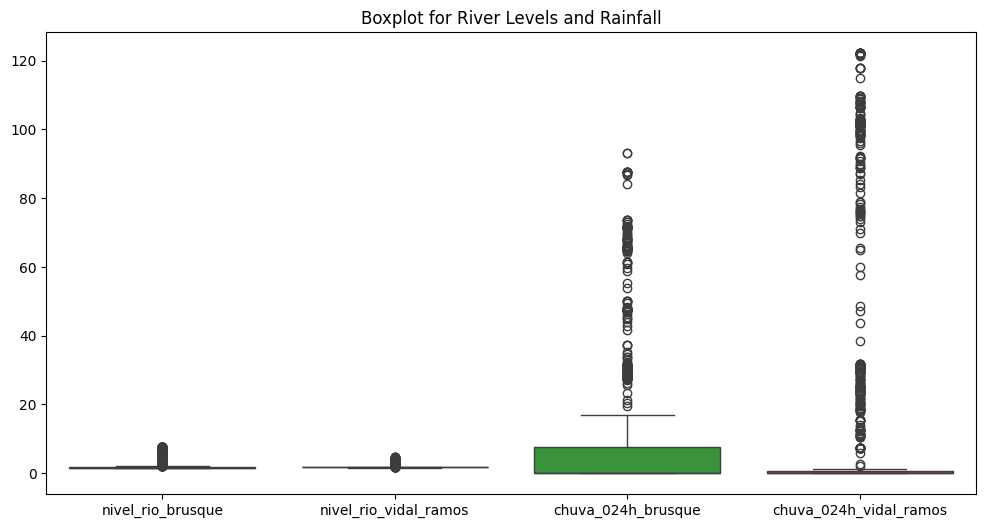

Correlation Matrix:
                        nivel_rio_brusque  nivel_rio_vidal_ramos  \
nivel_rio_brusque                1.000000               0.655586   
nivel_rio_vidal_ramos            0.655586               1.000000   
chuva_024h_brusque               0.936860               0.763822   
chuva_024h_vidal_ramos           0.869912               0.912227   

                        chuva_024h_brusque  chuva_024h_vidal_ramos  
nivel_rio_brusque                 0.936860                0.869912  
nivel_rio_vidal_ramos             0.763822                0.912227  
chuva_024h_brusque                1.000000                0.949361  
chuva_024h_vidal_ramos            0.949361                1.000000  


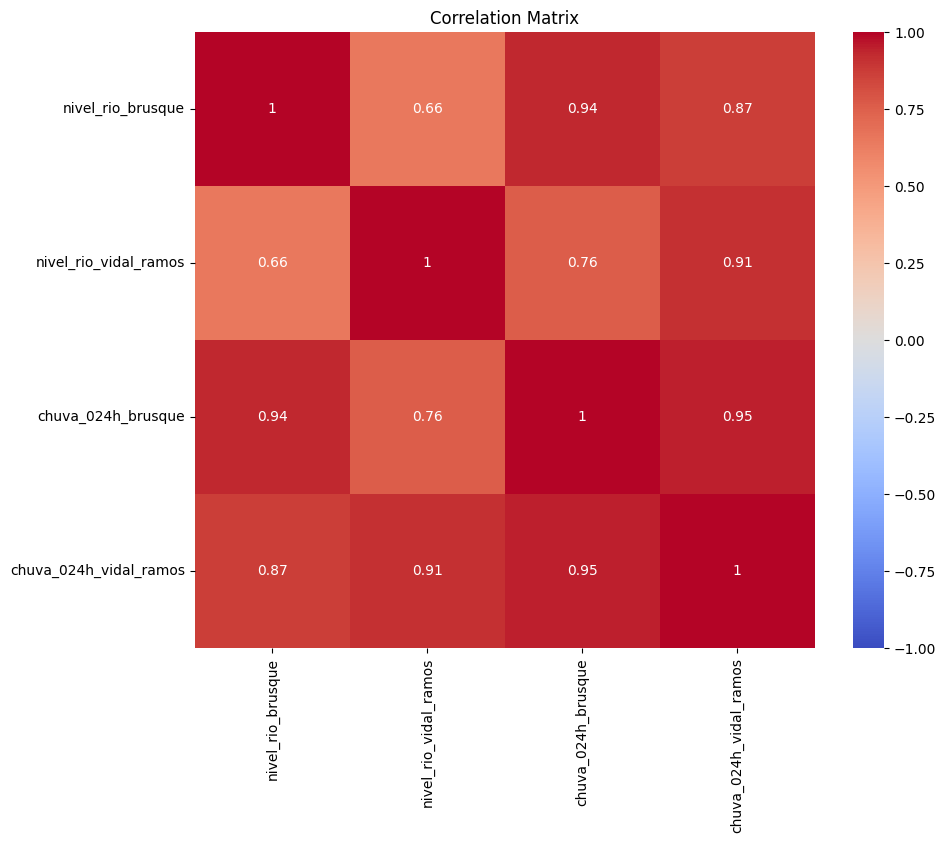

Number of outliers: 154
Data shape after removing outliers: (1548, 14)


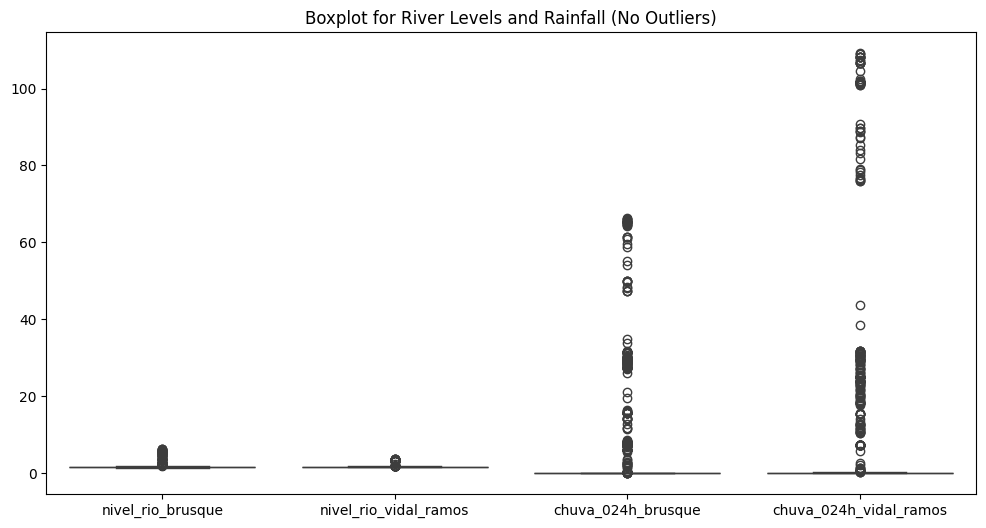

In [247]:
#%pip install seaborn
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows where river levels are not available
merged_data.dropna(subset=['nivel_rio_brusque', 'nivel_rio_vidal_ramos'], inplace=True)
print(f"Data shape after dropping NaNs: {merged_data.shape}")
print(merged_data.head())

# Drop rows where river levels are not available or invalid (zero values)
merged_data = merged_data[(merged_data['nivel_rio_brusque'] > 0) & (merged_data['nivel_rio_vidal_ramos'] > 0)]
print(f"Data shape after dropping zero values: {merged_data.shape}")
print(merged_data.head())

# Set the timestamp as the index
merged_data.set_index('timestamp', inplace=True)

# Ensure the index is a DatetimeIndex
merged_data.index = pd.to_datetime(merged_data.index)
print(f"Index after ensuring DatetimeIndex: {merged_data.index}")

# Sort the data by index
merged_data.sort_index(inplace=True)

# Print rows where river level in Brusque is greater than 20
high_river_levels = merged_data[merged_data['nivel_rio_brusque'] > 20]
print(f"Rows where river level in Brusque is greater than 20:\n{high_river_levels}")

# Dataset review
print("Dataset Review:")
print(merged_data.describe())

# Check for outliers using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data[['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']])
plt.title('Boxplot for River Levels and Rainfall')
plt.show()

# Check variable correlation
correlation_matrix = merged_data[['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Check for outliers using z-score
from scipy.stats import zscore

z_scores = np.abs(zscore(merged_data[['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']]))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

# Remove outliers
merged_data_no_outliers = merged_data[~outliers]
print(f"Data shape after removing outliers: {merged_data_no_outliers.shape}")

# Plot the data after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data_no_outliers[['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']])
plt.title('Boxplot for River Levels and Rainfall (No Outliers)')
plt.show()

In [248]:

# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')

Mean Squared Error: 0.0069


In [249]:
# Display last 5 predictions for validation
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).tail(20)
print("\nLast 20 Predictions:\n", comparison)


Last 20 Predictions:
      Actual  Predicted
1680   7.72     7.7075
101    1.67     1.6700
711    1.56     1.5600
107    1.67     1.6700
584    1.57     1.5700
1684    7.6     7.5876
493    1.58     1.5800
1260   1.48     1.4829
1488   6.58     6.5129
693    1.56     1.5600
1124    1.5     1.5000
1542   6.65     6.6634
1108    1.5     1.5000
128    1.67     1.6700
486    1.58     1.5800
836    1.53     1.5300
589    1.57     1.5681
1381   1.79     1.7917
414    1.61     1.6100
1068    1.5     1.5000


Comparação
[1.559999942779541 1.5399999618530271 2.5199999809265137 1.659999966621399
 1.590000033378601 8.479999542236328 1.5399999618530271 1.6299999952316284
 1.6100000143051147 1.7400000095367432 1.5399999618530271
 1.6299999952316284 1.7000000476837158 1.6100000143051147 8.5
 1.559999942779541 1.559999942779541 1.559999942779541 1.6100000143051147
 7.409999847412109 1.9299999475479128 1.590000033378601 1.7300000190734863
 7.489999771118164 1.5 1.5700000524520874 1.6100000143051147
 1.6699999570846558 1.6799999475479126 1.5 1.5800000429153442
 1.6799999475479126 1.5 1.4900000095367432 1.8200000524520876
 1.5399999618530271 1.4700000286102295 1.6299999952316284
 1.6100000143051147 1.4800000190734863 6.210000038146973 1.559999942779541
 1.590000033378601 1.590000033378601 1.6299999952316284 1.4800000190734863
 1.5700000524520874 1.6100000143051147 1.590000033378601
 1.7599999904632568 1.6100000143051147 6.460000038146973
 1.4800000190734863 1.4900000095367432 1.6799999475479126
 1.57

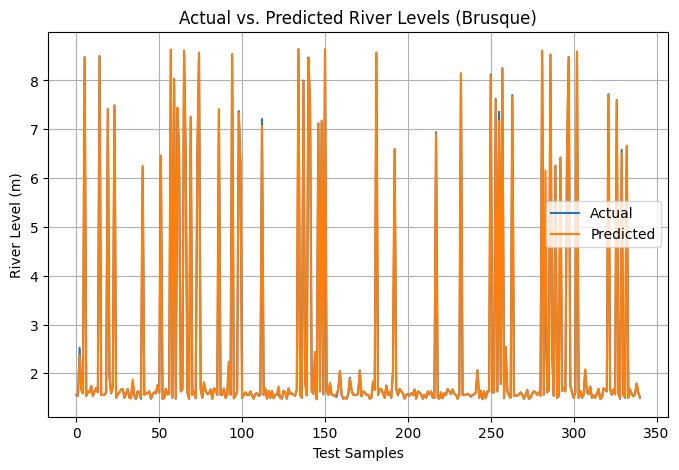

In [250]:
# Plot actual vs. predicted
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.plot(y_test.values, label='Actual')
print("Comparação")
print(y_test.values)
print(y_pred)
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs. Predicted River Levels (Brusque)")
plt.xlabel("Test Samples")
plt.ylabel("River Level (m)")
plt.legend()
plt.grid()
plt.show()

In [251]:
def predict_next_day_river_level(latest_data=None):
    """
    Predict the next day's river level for Brusque.

    Parameters:
    latest_data (list or None): If None, uses the last row of the test set.
                                Otherwise, provide a list [nivel_rio_brusque_lag1, nivel_rio_vidal_ramos_lag1, chuva_024h_brusque_lag1, chuva_024h_vidal_ramos_lag1].

    Returns:
    float: Predicted river level for the next day.
    """
    # Check if provided data is None, use the last row from X_test
    if latest_data is None:
        try:
            latest_data = X_test.iloc[-1].values
            print("Using the last test row for prediction:", latest_data)
        except Exception as e:
            print(f"Error accessing the last row of X_test: {e}")
            return None
    else:
        # Ensure the provided data is in the correct format (list with expected length)
        if not isinstance(latest_data, list) or len(latest_data) != len(X.columns):
            print(f"Invalid input data: Expected a list with {len(X.columns)} values.")
            return None
        print("Using provided data for prediction:", latest_data)

    # Convert latest_data to a DataFrame with appropriate columns
    try:
        latest_data_df = pd.DataFrame([latest_data], columns=X.columns)
    except Exception as e:
        print(f"Error creating DataFrame: {e}")
        return None

    # Make prediction using the trained model
    try:
        prediction = model.predict(latest_data_df)[0]
        print(f"Predicted river level for the next day: {prediction}")
        return prediction
    except Exception as e:
        print(f"Error making prediction: {e}")
        return None


In [252]:
# Example: Predict using the last test set row
predicted_river_level = predict_next_day_river_level()
print(f"Predicted river level for the next day in Brusque: {predicted_river_level:.2f}")

Using the last test row for prediction: [np.float64(1.5399999618530271) np.float64(0.0)
 np.float64(1.6399999856948853) np.float64(0.0) 1.9299999475479128
 1.7899999618530271 0.0 0.0 np.float64(6835.207216)
 np.float64(6835.207216) np.float64(6835.207216) np.float64(6835.207216)]
Predicted river level for the next day: 1.5
Predicted river level for the next day in Brusque: 1.50


### Add more tests to evaluate the performance of the solution

In [253]:
start_index = 130
end_index = 140
test_file_names = [f"./dataset/data_log_{i}.csv" for i in range(start_index, end_index + 1)]

# Load CSV files with error handling
test_files = []
for file in test_file_names:
    try:
        tf = pd.read_csv(file, names=columns, header=0)  # Skip the header row in all files
        test_files.append(tf)
        print(f"Successfully loaded {file}")
    except FileNotFoundError:
        print(f"Error: {file} not found.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse {file}.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if len(test_files) == 0:
    raise Exception("No valid files were loaded. Please check the file paths or file content.")

test_data = pd.concat(test_files)

print(f"Test data shape: {test_data.shape}")

Successfully loaded ./dataset/data_log_130.csv
Successfully loaded ./dataset/data_log_131.csv
Successfully loaded ./dataset/data_log_132.csv
Successfully loaded ./dataset/data_log_133.csv
Successfully loaded ./dataset/data_log_134.csv
Successfully loaded ./dataset/data_log_135.csv
Successfully loaded ./dataset/data_log_136.csv
Successfully loaded ./dataset/data_log_137.csv
Successfully loaded ./dataset/data_log_138.csv
Successfully loaded ./dataset/data_log_139.csv
Successfully loaded ./dataset/data_log_140.csv
Test data shape: (105111, 33)


In [254]:
# Convert timestamp to datetime with timezone information
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'], utc=True)

# Filter data for the selected stations
test_filtered_data = test_data[test_data['nome'].isin(stations)]
print(f"Additional filtered data shape: {test_filtered_data.shape}")


Additional filtered data shape: (4890, 33)


In [255]:

# Pivot data to have separate columns for each station's data
test_pivoted_data = test_filtered_data.pivot_table(index="timestamp", columns="nome", values=["nivel_rio", "chuva_024h"])
test_pivoted_data.columns = ['nivel_rio_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_brusque', 'chuva_024h_vidal_ramos']
test_pivoted_data.reset_index(inplace=True)
test_pivoted_data.sort_values(by="timestamp", inplace=True)
print(f"Additional pivoted data shape: {test_pivoted_data.shape}")

# Merge Brusque and Vidal Ramos data based on the closest timestamp within a 5-minute difference
test_merged_data = pd.merge_asof(
    test_pivoted_data[['timestamp', 'nivel_rio_brusque', 'chuva_024h_brusque']],
    test_pivoted_data[['timestamp', 'nivel_rio_vidal_ramos', 'chuva_024h_vidal_ramos']],
    on='timestamp',
    tolerance=pd.Timedelta('5 minutes'),
    direction='nearest'
)
print(f"Additional merged data shape: {test_merged_data.shape}")


Additional pivoted data shape: (2445, 5)
Additional merged data shape: (2445, 5)


In [256]:
# Drop rows where river levels are not available
test_merged_data.dropna(subset=['nivel_rio_brusque', 'nivel_rio_vidal_ramos'], inplace=True)
print(f"Additional data shape after dropping NaNs: {test_merged_data.shape}")

# Drop rows where river levels are not available or invalid (zero values)
test_merged_data = test_merged_data[(test_merged_data['nivel_rio_brusque'] > 0) & (test_merged_data['nivel_rio_vidal_ramos'] > 0)]
print(f"Additional data shape after dropping zero values: {test_merged_data.shape}")


Additional data shape after dropping NaNs: (2445, 5)
Additional data shape after dropping zero values: (578, 5)


In [257]:
# Set the timestamp as the index
test_merged_data.set_index('timestamp', inplace=True)
# Ensure the index is a DatetimeIndex
merged_data.index = pd.to_datetime(merged_data.index)
print(f"Index after ensuring DatetimeIndex: {merged_data.index}")

merged_data.sort_index(inplace=True)


Index after ensuring DatetimeIndex: DatetimeIndex(['2023-11-07 21:08:44.725020+00:00',
               '2023-11-07 21:13:45.289747+00:00',
               '2023-11-07 21:18:45.867771+00:00',
               '2023-11-07 21:23:46.464521+00:00',
               '2023-11-07 21:28:47.013901+00:00',
               '2023-11-07 21:33:47.573882+00:00',
               '2023-11-07 21:38:48.168629+00:00',
               '2023-11-07 21:43:48.750415+00:00',
               '2023-11-07 21:48:49.330921+00:00',
               '2023-11-07 21:53:49.893794+00:00',
               ...
               '2023-11-17 03:14:09.016828+00:00',
               '2023-11-17 03:19:12.376012+00:00',
               '2023-11-17 03:24:15.762059+00:00',
               '2023-11-17 03:29:20.065577+00:00',
               '2023-11-17 03:34:23.328723+00:00',
               '2023-11-17 03:39:27.247986+00:00',
               '2023-11-17 03:44:30.889691+00:00',
               '2023-11-17 03:49:35.164355+00:00',
               '2023-11-17 

In [258]:

# Create columns to store lag values and lag durations
test_merged_data['nivel_rio_brusque_lag24h'] = None
test_merged_data['nivel_rio_vidal_ramos_lag24h'] = None
test_merged_data['chuva_024h_brusque_lag24h'] = None
test_merged_data['chuva_024h_vidal_ramos_lag24h'] = None

test_merged_data['nivel_rio_brusque_lag_duration'] = None
test_merged_data['nivel_rio_vidal_ramos_lag_duration'] = None
test_merged_data['chuva_024h_brusque_lag_duration'] = None
test_merged_data['chuva_024h_vidal_ramos_lag_duration'] = None

# Iterate over the rows to find the first valid lag greater than 24 hours
for i, row in test_merged_data.iterrows():
    # Get the current row's timestamp
    current_timestamp = row.name  # 'row.name' gives the index, which is the timestamp in your case
    
    # Check previous rows for a lag greater than 24 hours
    for j, other_row in test_merged_data.iterrows():
        # Calculate the time difference
        time_diff = current_timestamp - other_row.name
        
        # If the lag is greater than 24 hours, use the value from that row
        if time_diff > pd.Timedelta(hours=24):
            # Store the lagged values
            test_merged_data.at[i, 'nivel_rio_brusque_lag24h'] = other_row['nivel_rio_brusque']
            test_merged_data.at[i, 'nivel_rio_vidal_ramos_lag24h'] = other_row['nivel_rio_vidal_ramos']
            test_merged_data.at[i, 'chuva_024h_brusque_lag24h'] = other_row['chuva_024h_brusque']
            test_merged_data.at[i, 'chuva_024h_vidal_ramos_lag24h'] = other_row['chuva_024h_vidal_ramos']

            # Store the lag duration
            test_merged_data.at[i, 'nivel_rio_brusque_lag_duration'] = time_diff
            test_merged_data.at[i, 'nivel_rio_vidal_ramos_lag_duration'] = time_diff
            test_merged_data.at[i, 'chuva_024h_brusque_lag_duration'] = time_diff
            test_merged_data.at[i, 'chuva_024h_vidal_ramos_lag_duration'] = time_diff
            
            break  # Stop once the first valid lag is found

# Drop rows where no lag was found
test_merged_data.dropna(subset=['nivel_rio_brusque_lag24h', 'nivel_rio_vidal_ramos_lag24h'], inplace=True)


In [259]:
# Create new columns for the next day's values and duration
test_merged_data['nivel_rio_brusque_next_day'] = None
test_merged_data['nivel_rio_brusque_next_day_duration'] = None

# Iterate over the rows to find the first valid target (next day's value)
for i, row in test_merged_data.iterrows():
    # Get the current row's timestamp
    current_timestamp = row.name  # 'row.name' gives the index (timestamp)
    
    # Check future rows for a lag greater than 24 hours
    for j, future_row in test_merged_data.iterrows():
        if j <= i:
            continue  # Skip if we're looking at the current or past rows
        
        future_timestamp = future_row.name  # Get the future row's timestamp
        
        # Calculate the time difference
        time_diff = future_timestamp - current_timestamp
        
        # If the time difference is greater than 24 hours, use that future value
        if time_diff > pd.Timedelta(hours=24):
            # Store the future river level as the target variable
            test_merged_data.at[i, 'nivel_rio_brusque_next_day'] = future_row['nivel_rio_brusque']
            test_merged_data.at[i, 'nivel_rio_brusque_next_day_duration'] = time_diff
            break  # Stop once we find the first valid future value

# Drop rows where no valid future value was found
test_merged_data.dropna(subset=['nivel_rio_brusque_next_day'], inplace=True)

# Inspect the resulting data with the next day's column
print(test_merged_data.head())
# Create the target variable (next day's river level in Brusque)
#test_merged_data['nivel_rio_brusque_next_day'] = test_merged_data['nivel_rio_brusque'].shift(-24, freq='H')

# Drop missing values
test_merged_data.dropna(inplace=True)
print(f"Data shape after dropping NaNs for lagged features: {test_merged_data.shape}")

# Reset the index to have timestamp as a column again
test_merged_data.reset_index(inplace=True)

# Show the rows data
test_merged_data.info()

                                  nivel_rio_brusque  chuva_024h_brusque  \
timestamp                                                                 
2024-04-05 17:20:09.505928+00:00               0.37                1.05   
2024-04-05 17:25:09.692724+00:00               2.31                1.05   
2024-04-05 17:30:09.868154+00:00               2.31                1.05   
2024-04-05 17:35:10.096791+00:00               2.31                1.05   
2024-04-05 17:40:10.285557+00:00               2.31                1.05   

                                  nivel_rio_vidal_ramos  \
timestamp                                                 
2024-04-05 17:20:09.505928+00:00                  11.24   
2024-04-05 17:25:09.692724+00:00                  11.81   
2024-04-05 17:30:09.868154+00:00                  11.98   
2024-04-05 17:35:10.096791+00:00                  12.38   
2024-04-05 17:40:10.285557+00:00                  12.63   

                                  chuva_024h_vidal_ramos  \


In [260]:

# Convert Timedelta columns to Timedelta type
test_merged_data['nivel_rio_brusque_lag_duration'] = pd.to_timedelta(test_merged_data['nivel_rio_brusque_lag_duration'])
test_merged_data['nivel_rio_vidal_ramos_lag_duration'] = pd.to_timedelta(test_merged_data['nivel_rio_vidal_ramos_lag_duration'])
test_merged_data['chuva_024h_brusque_lag_duration'] = pd.to_timedelta(test_merged_data['chuva_024h_brusque_lag_duration'])
test_merged_data['chuva_024h_vidal_ramos_lag_duration'] = pd.to_timedelta(test_merged_data['chuva_024h_vidal_ramos_lag_duration'])


# Prepare features and target
X = test_merged_data[['nivel_rio_brusque', 'chuva_024h_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_vidal_ramos','nivel_rio_brusque_lag24h', 'nivel_rio_vidal_ramos_lag24h', 'chuva_024h_brusque_lag24h', 'chuva_024h_vidal_ramos_lag24h', 'nivel_rio_brusque_lag_duration', 'nivel_rio_vidal_ramos_lag_duration', 'chuva_024h_brusque_lag_duration', 'chuva_024h_vidal_ramos_lag_duration']]
y = test_merged_data['nivel_rio_brusque_next_day']

# Show the first few rows of the additional data
print(test_merged_data.head())

# Prepare features for prediction
X_additional = test_merged_data[['nivel_rio_brusque', 'chuva_024h_brusque', 'nivel_rio_vidal_ramos', 'chuva_024h_vidal_ramos',
                                       'nivel_rio_brusque_lag24h', 'nivel_rio_vidal_ramos_lag24h', 'chuva_024h_brusque_lag24h', 'chuva_024h_vidal_ramos_lag24h',
                                       'nivel_rio_brusque_lag_duration', 'nivel_rio_vidal_ramos_lag_duration', 'chuva_024h_brusque_lag_duration', 'chuva_024h_vidal_ramos_lag_duration']]
# Convert Timedelta columns to numeric values (e.g., total seconds or hours)
X_additional['nivel_rio_brusque_lag_duration'] = test_merged_data['nivel_rio_brusque_lag_duration'].dt.total_seconds() / 60
X_additional['nivel_rio_vidal_ramos_lag_duration'] = test_merged_data['nivel_rio_vidal_ramos_lag_duration'].dt.total_seconds() / 60
X_additional['chuva_024h_brusque_lag_duration'] = test_merged_data['chuva_024h_brusque_lag_duration'].dt.total_seconds() / 60
X_additional['chuva_024h_vidal_ramos_lag_duration'] = test_merged_data['chuva_024h_vidal_ramos_lag_duration'].dt.total_seconds() / 60


                         timestamp  nivel_rio_brusque  chuva_024h_brusque  \
0 2024-04-05 17:20:09.505928+00:00               0.37                1.05   
1 2024-04-05 17:25:09.692724+00:00               2.31                1.05   
2 2024-04-05 17:30:09.868154+00:00               2.31                1.05   
3 2024-04-05 17:35:10.096791+00:00               2.31                1.05   
4 2024-04-05 17:40:10.285557+00:00               2.31                1.05   

   nivel_rio_vidal_ramos  chuva_024h_vidal_ramos nivel_rio_brusque_lag24h  \
0                  11.24                    1.59                     0.04   
1                  11.81                    1.59                     0.04   
2                  11.98                    1.59                     0.04   
3                  12.38                    1.59                     0.04   
4                  12.63                    1.59                     0.04   

  nivel_rio_vidal_ramos_lag24h chuva_024h_brusque_lag24h  \
0             

C:\Users\Klaus\AppData\Local\Temp\ipykernel_2432\2240880236.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_additional['nivel_rio_brusque_lag_duration'] = test_merged_data['nivel_rio_brusque_lag_duration'].dt.total_seconds() / 60
C:\Users\Klaus\AppData\Local\Temp\ipykernel_2432\2240880236.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_additional['nivel_rio_vidal_ramos_lag_duration'] = test_merged_data['nivel_rio_vidal_ramos_lag_duration'].dt.total_seconds() / 60
C:\Users\Klaus\AppData\Local\T

In [261]:
# import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have a trained model named 'model'
# Predict the next day's river level in Brusque
predictions = model.predict(X_additional)

# Compare predictions with actual values
actual_values = []
for i, prediction in enumerate(predictions):
    # Get the timestamp of the current row
    current_timestamp = additional_merged_data.iloc[i]['timestamp']
    
    # Find the closest actual value in the dataset
    closest_row = merged_data.iloc[(merged_data['timestamp'] - current_timestamp).abs().argsort()[:1]]
    actual_value = closest_row['nivel_rio_brusque_next_day'].values[0]
    actual_values.append(actual_value)
    
    print(f"Prediction: {prediction}, Actual: {actual_value}, Timestamp: {current_timestamp}")

# Convert lists to arrays for easier manipulation
predictions = np.array(predictions)
actual_values = np.array(actual_values)

# Calculate metrics
mse = mean_squared_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.xlabel('Sample Index')
plt.ylabel('River Level (Brusque)')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()

# # Scatter plot of predictions vs actual values
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=actual_values, y=predictions)
# plt.xlabel('Actual Values')
# plt.ylabel('Predictions')
# plt.title('Scatter Plot of Predictions vs Actual Values')
# plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
# plt.show()

# # Residual plot
# residuals = actual_values - predictions
# plt.figure(figsize=(10, 6))
# sns.histplot(residuals, kde=True)
# plt.xlabel('Residuals')
# plt.title('Residuals Distribution')
# plt.show()

NameError: name 'additional_merged_data' is not defined